# Purpose of this Notebook

This notebook is based on **Andrej Karpathy**'s [`micrograd` library](https://github.com/karpathy/micrograd) and his wonderful accompanying tutorial video [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0).

[Learning representations by back-propagating errors (Rumelhart et al., 1986)](https://www.nature.com/articles/323533a0) is an early and very dense (< 3 pages) paper on the topic of backpropagation.

Knowledge about basic calculus is assumed, but not more. The purpose of this notebook is to derive how the **training of neural networks via backpropagation** works. To that end both the backpropagation algorithm and the architecture of a simple multilayer perceptron (MLP are **implemented from scratch**.

The code implements backpropagation (reverse-mode autodiff) and can be used for functions in general, not only neural networks (which are a certain class of mathematical expressions).

Obviously the code running in practice is heavily optimized and working with *tensors* (instead of *scalars*), but the **underlying math and principles are the same**.

# Setup Code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

Code to visualize the computation graphs

In [2]:
from graphviz import Digraph

def trace(root):
  # Builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      # If this value os a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)
  
  for n1, n2 in edges:
    # Connect n1, n2 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot

# What is a Derivative?

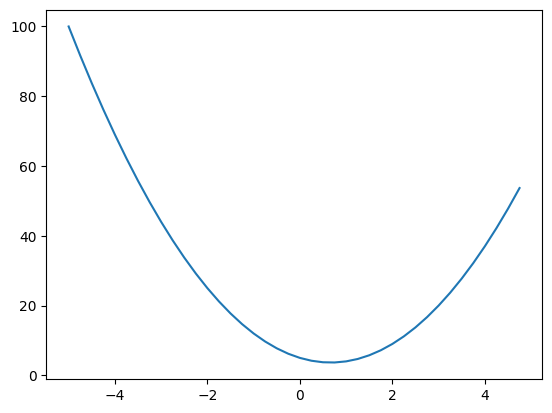

In [3]:
def f(x):
  """Arbitrary function for demo purposes."""
  return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)  # Array of sequence of numbers
ys = f(xs)                   # Function values at given x values

plt.plot(xs, ys)             # Plot the function

The formula to calculate the difference quotient is $$\underset{h → 0}{\lim}\frac{f(x+h)-f(x)}{h}$$
By choosing a smaller and smaller value for $h$, it computes a numerical approximation of the slope of $f$ at the point $x$.

*Experiment with different values for $h$ and $x$:*

In [4]:
h = 0.0001       # Choose a small value for h
x = 3.0          # Choose the point where to compute the slope
(f(x+h)-f(x))/h  # Calculate the difference quotient: 14.0003 -> Slope at x = 3.0 is 14

14.000300000063248

Moving to *multivariate* calculus (functions of multiple variables).

In [5]:
def d(a, b, c):
  """Multivariate function for demo purposes."""
  return a*b+c

# Choose inputs
a = 2.0
b = -3.0
c = 10.0

h = 0.0001

# Function evaluations
d1 = d(a,b,c)    # At current point
d2 = d(a+h,b,c)  # At slightly different point
print(f"d1 = {d1}, d2 = {d2}, slope = {(d2-d1)/h}")  # Slope at given point with respect to a is -3

d1 = d(a,b,c)
d2 = d(a,b+h,c)
print(f"d1 = {d1}, d2 = {d2}, slope = {(d2-d1)/h}")  # Slope at given point with respect to b is 2

d1 = d(a,b,c)
d2 = d(a,b,c+h)
print(f"d1 = {d1}, d2 = {d2}, slope = {(d2-d1)/h}")  # Slope at given point with respect to c is 1

d1 = 4.0, d2 = 3.999699999999999, slope = -3.000000000010772
d1 = 4.0, d2 = 4.0002, slope = 2.0000000000042206
d1 = 4.0, d2 = 4.0001, slope = 0.9999999999976694


# Implementing the `Value` Class

Functions for the `Value` class can be defined at **different levels of abstraction**. E.g. `tanh()` involves multiple "basic" functions like addition, subtraction, division and exponentiation. It is only important that we **know the local derivative** of all nodes!

In [6]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0                # For backward pass: gradient with respect to loss
    self._backward = lambda: None  # For backward pass: Function applying the chain rule: local gradient * output gradient
    self._prev = set(_children)    # For backward pass/visualization: predecessors of this node
    self._op = _op                 # For forward/backward pass: operation that produced this node
    self.label = label             # For visualization: display name for the node
  
  def __add__(self, other):
    """Called by "self + other"."""
    other = other if isinstance(other, Value) else Value(other)  # Allows to add values of other classes to Value objects by wrapping them in a Value object
    out = Value(self.data + other.data, (self, other), '+')      # The output of the add operation is the sum of the respective values, and the children are the summands

    def _backward():                # Called by backward() of Value class
      # Important to use '+=' and not only '=' (accumulating the gradient)
      # Otherwise: bug, if variable is used more than once
      self.grad += 1.0 * out.grad   # local derivative of add operation wrt self node * output gradient ("out.grad is chained through local gradient into self.grad")
      other.grad += 1.0 * out.grad  # local derivative of add operation wrt other node * output gradient
    out._backward = _backward

    return out

  def __mul__(self, other):
    """Called by "self * other"."""
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad  # local derivative of multiplication * output gradient
      other.grad += self.data * out.grad
    out._backward = _backward
  
    return out

  def __pow__(self, other):
    """Called by "self ** other"."""
    assert isinstance(other, (int, float)), "Only supporting int/float powers for now."
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad  # local derivative of power operation * output gradient
    out._backward = _backward

    return out

  def tanh(self):
    """Implements hyperbolic tangent function as an example of an activation function."""
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad  # local derivative of tanh operation * output gradient
    out._backward = _backward
    
    return out

  def exp(self):
    """Implements e**x."""
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad  # local derivative of exp operation * output gradient
    
    out._backward = _backward
    return out

  def backward(self):
    """Function performing the whole backward pass."""
    # First, the computation graph has to be sorted topologically
    # A *topological sort* lays out a graph so that all edges only go from left to right
    # This is done to ensure that the _backward() functions are called in the right order
    # (only if _backward() of the later node(s) were already called)
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # Accumulate gradients by passing from back to front of the graph
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  # --- Other functions that can be reduced to already implemented functions. ---

  def __neg__(self):
    """Called by "-self"."""
    return self * -1

  def __sub__(self, other):
    """Called by "self - other"."""
    return self + (-other)

  def __truediv__(self, other):
    """Called by "self / other"."""
    return self * other**-1

  def __radd__(self, other):
    """Called by "other + self"."""
    return self + other

  def __rsub__(self, other):
    """Called by "other - self"."""
    return other + (-self)

  def __rmul__(self, other):
    """Called by "other * self"."""
    return self * other

  def __rtruediv__(self, other):
    """Called by "other / self"."""
    return other * self**-1

  def __repr__(self):
    """Called by print() function."""
    return f"Value(data={self.data})"

# Using the `Value` Class for the *Forward Pass*

The *forward pass* simply refers to calculating the value of a function with given inputs.

In [7]:
# Inputs
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

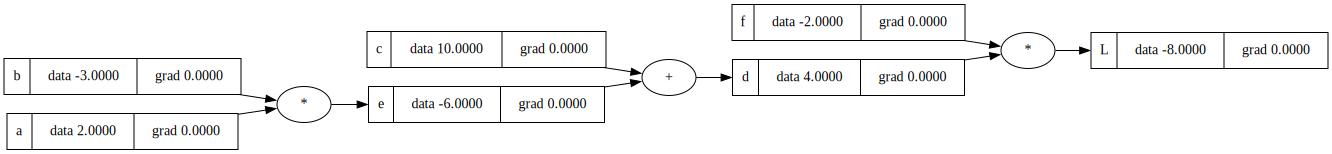

In [8]:
# Function
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

# Visualize the forward pass of the calculation of L (draw_dot() is defined in the "Setup" section)
draw_dot(L)

# Manual *Backward Pass* (not using `_backward()` and `backward()` of `Value` class)

Backpropagation refers to **calculating the derivative of every node** of the computation graph with respect to the loss, $L$. This is done by *recursive application of chain rule* backwards through the computation graph.

Later, the nodes will be weights of a neural network.

Recall that the derivative refers to the rate of change of $L$, if I change the input by $1$ unit.

For $L$ itself, it is simple: $\frac{\partial L}{\partial L} = 1$

In [9]:
L.grad = 1.0

From the computation graph, we know that $L$ depends on $d$ and $f$ in the following way: $$L(d, f) = d \cdot f$$

Now we calculate $\frac{\partial L}{\partial d} = f$ and $\frac{\partial L}{\partial f} = d$ by applying the *constant factor rule* (as we see $f$ as a constant when deriving with respect to $d$ and the other way round.)

Thus, we set:

In [10]:
d.grad = -2.0
f.grad = 4.0

The next step to calculate $\frac{\partial L}{\partial c}$ and $\frac{\partial L}{\partial e}$ is a bit harder.

First, we know how $c$ and $e$ influcene $d$: $$d(c, e) = c + e$$
Thus we also know the **local derivatives**: $\frac{\partial d}{\partial c} = 1$ and $\frac{\partial d}{\partial e} = 1$.

The following is the **most important thing to understand in this notebook**:
***We can apply the chain rule to compute how to chain derivatives together correctly!***

The formula for the chain rule looks like this: $\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \cdot \frac{\partial y}{\partial x}$.
> Intuitively, the chain rule states that knowing the instantaneous rate of change of $z$ relative to $y$ and that of $y$ relative to $x$ allows one to calculate the instantaneous rate of change of $z$ relative to $x$ as the product of the two rates of change. ~ [Chain rule (Wikipedia)](https://en.wikipedia.org/wiki/Chain_rule)

By chaining together the already computed derivative of $L$ with regard to $d$ ($\frac{\partial L}{\partial d} = f$) and the local derivative of $d$ with regard to $c$ ($\frac{\partial d}{\partial c} = 1$), we can compute:
$$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c} = f \cdot 1$$
which is exactly what we are looking for.

Equivalently for $e$:
$$\frac{\partial L}{\partial e} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial e} = f \cdot 1$$

We see that the $+$ node simply "routes" the gradient unchanged, because the local derivative is always equal to 1.

In [11]:
c.grad = -2.0
e.grad = -2.0

We can calculate $\frac{\partial L}{\partial a}$ and $\frac{\partial L}{\partial b}$ in the same way.

First, we know how $a$ and $b$ influence $e$: $$e(a,b) = a \cdot b$$
The local derivatives are thus: $\frac{\partial e}{\partial a} = b$ and $\frac{\partial e}{\partial b} = a$.

The gradient of the output node is: $\frac{\partial L}{\partial e} = f$.

Thus, we obtain:
$$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial a} = f \cdot b$$
and:
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial b} = f \cdot a$$

In [12]:
a.grad = 6.0   # = -2.0 * -3.0
b.grad = -4.0  # = -2.0 * 2.0

When we draw the computation graph again, we see that the gradient values are set.

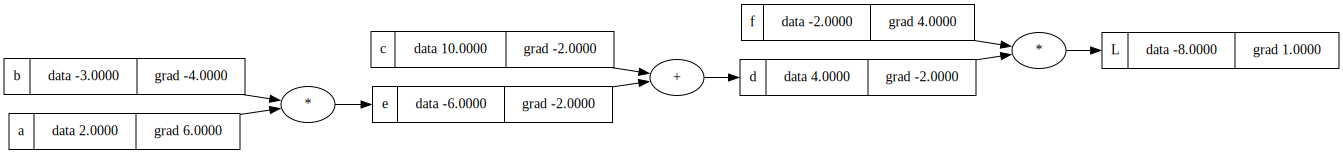

In [13]:
draw_dot(L)

We did one *backward pass* by hand :)

Now that we know how every variable (locally) influences the function output, we know how to change them to minimize/maximize the output.

At the end, that is exactly what we want to do: The function is our neural network and the variables are the weights of the network, which we want to tune in order to minimize the loss of our network.

# Mimicking a Simple Neuron and Using `backward()` for the *Backward Pass*

tanh Activation function:

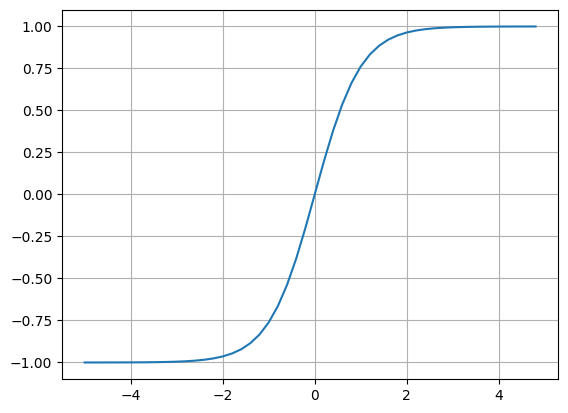

In [14]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

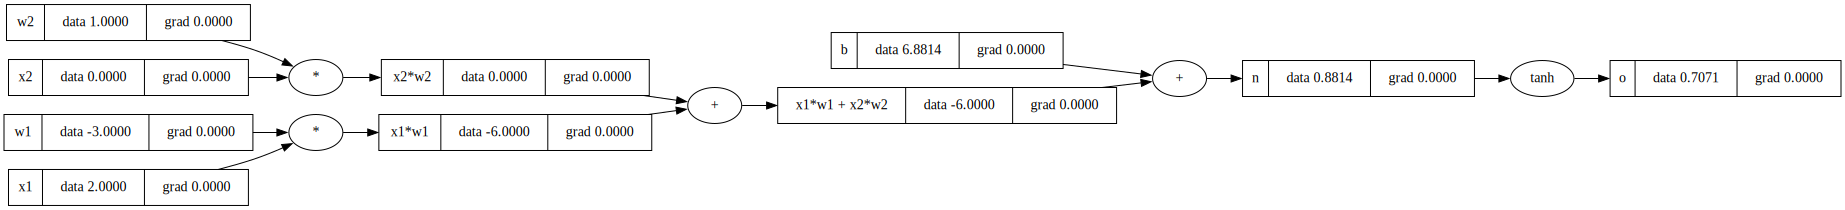

In [19]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron (weird value to obtain prettier derivatives)
b = Value(6.8813735870195432, label='b')

# Computation of the neuron (weighted sum): x1*w1 + x2*w2 - b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

# Output = activation function(weighted sum)
o = n.tanh(); o.label = 'o'

draw_dot(o)

Manual backpropagation:

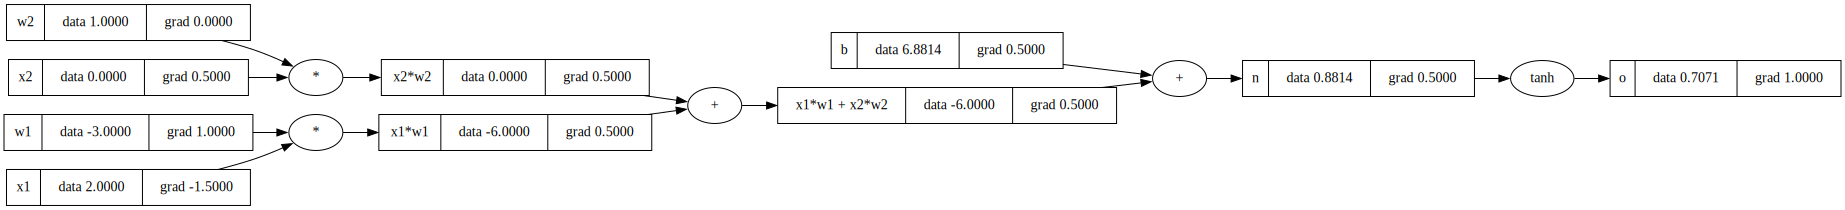

In [16]:
o.grad = 1.0
# o = tanh(n) -> do/dn = 1 - tanh(n)**2 = 1 - o**2
n.grad = 0.5  # = 1 - o.data**2
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
draw_dot(o)

Backpropagation calling `_backward()` helper methods implemented for every function in `Value` class individually:

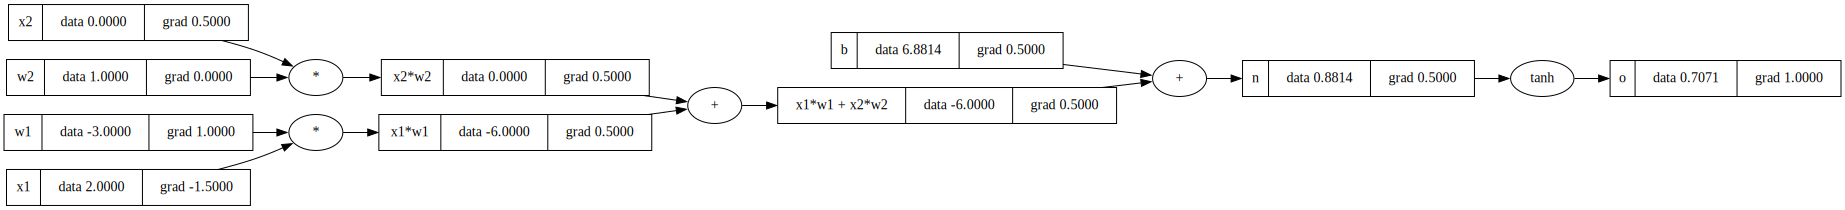

In [18]:
# Execute second cell of this section again to erase the gradient already computed above
# Otherwise the gradient will be wrong, as it gets accumulated!
o.grad = 1.0
o._backward()
n._backward()
b._backward()  # Nothing happens, as it is a leaf node
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

We don't want to call `_backward()` ourselves all the time.

$→$ Implement `backward()` function to `Value` class which handles the recursive calls to the individual `_backward()` functions.

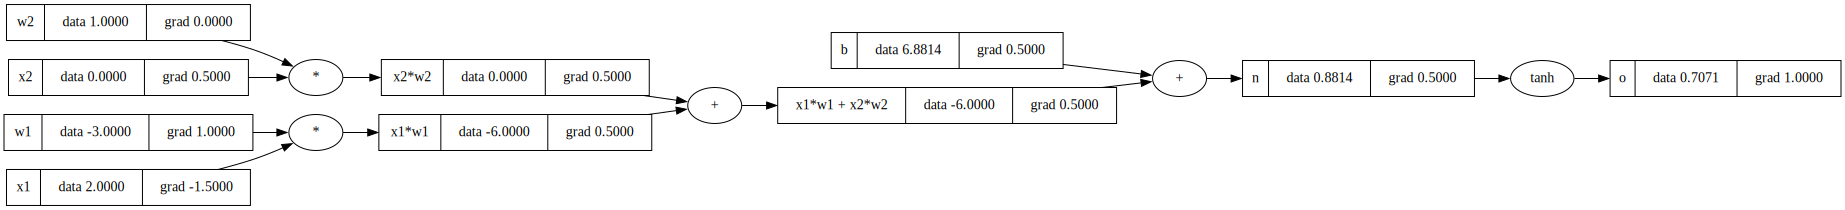

In [20]:
# Execute second cell of this section again to erase the gradient already computed above
# Otherwise the gradient will be wrong, as it gets accumulated!
o.backward()
draw_dot(o)

# Doing Backpropagation With `pytorch`

Using `pytorch` works in the same way, but more efficient, as `Tensor`s are used (enables parallelism).

In [21]:
import torch

x1 = torch.Tensor([2.0]).double();               x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();              x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();               w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();               w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---\nGradients:")
print("x1:", x1.grad.item())
print("x2:", x2.grad.item())
print("w1:", w1.grad.item())
print("w2:", w2.grad.item())

0.7071066904050358
---
Gradients:
x1: -1.5000003851533106
x2: 0.5000001283844369
w1: 1.0000002567688737
w2: 0.0


# Implementing the `Neuron`, `Layer`, and `MLP` Classes

Remember that neural networks are just a certain class of mathematical expressions.

They have *data* and their *weights* as inputs and output *predictions*.

Although they usually are not written out as a whole mathematical function because they are just soo *massive*. This also means that symbolic differentiation to calculate an optimum is not feasable which is why we resolve to backpropagation.

In [22]:
class Module:
  """Base class every component of neural networks inherits from.

  Mimicks the architecture of pytorch."""


  def zero_grad(self):
    """Reset the grad value for all parameters.

    Because we accumulate the gradient values (+=), we have to set them to 0
    when we calculate the gradient the next time.
    """
    for p in self.parameters():
      p.grad = 0

  def parameters(self):
    return []


class Neuron(Module):

  def __init__(self, nin):
    """Initialize the neuron by setting the weights and the bias to random values.
 
    Args:
      nin (int): Number of inputs to the neuron."""
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    """Called when executing 'Neuron(nin)(x)'.

    Calculates the weighted sum of its inputs (w*x+b) 
    and applies tanh as the activation function.

    Args:
      x (list(int)): Input to the neuron"""
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    """Reuturn all parameter values of the neuron."""
    return self.w + [self.b]  # Last value is bias

  def __repr__(self):
    return f"Neuron{self.parameters()}"


class Layer(Module):

  def __init__(self, nin, nout):
    """Initialize the layer by initializing its neurons.

    Args:
      nin (int): Number of inputs to each neuron.
      nout (int): Number of neurons of the layer."""
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    """Called when executing 'Layer(nin, nout)(x)'.
    
    Calculates the outputs of all the layers neurons.

    Args:
      x (list(int)): Input to the layer."""
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out   # Single value if the layer has only 1 neuron, otherwise a list of values

  def parameters(self):
    """Reuturn all parameter values of the layer."""
    return [p for neuron in self.neurons for p in neuron.parameters()]

  def __repr__(self):
    return f"Layer[#{f',#'.join(str(neuron) for neuron in self.neurons)}\n\t]".replace("#", "\n\t\t")


class MLP(Module):

  def __init__(self, nin, nouts):
    """Initialize the MLP by initializing its layers.

    Args:
      nin (int): Number of inputs to the MLP's first layer.
      nouts (list(int)): Number of neurons of the layers."""
    nneurons =  [nin] + nouts
    self.layers = [Layer(nneurons[i], nneurons[i+1]) for i in range(len(nouts))]  # nouts layers with the number of each layers inputs corresponding to the number of outputs of the previous layer

  def __call__(self, x):
    """Called when executing 'MLP(nin, nouts)(x)'.
    
    Calculates the outputs of the MLP.

    Args:
      x (list(int)): Input to the MLP."""
    for layer in self.layers:  # Call all layers sequentially
      x = layer(x)
    return x

  def parameters(self):
    """Reuturn all parameter values of the MLP."""
    return [p for layer in self.layers for p in layer.parameters()]

  def __repr__(self):
    return f"MLP[\n\t{f',#'.join(str(layer) for layer in self.layers)}\n]".replace("#", "\n\t")

With this code, we can define a simple MLP and look at it's parameters:

# Creating an MLP and Optimizing it with Backpropagation

In [23]:
n = MLP(3, [4, 4, 1])
print(n)

MLP[
	Layer[
		Neuron[Value(data=0.46509226209490984), Value(data=0.6967055922040375), Value(data=0.5866746515003851), Value(data=-0.19630155037062957)],
		Neuron[Value(data=0.5873776511693247), Value(data=-0.4680205095131671), Value(data=0.2653868762412064), Value(data=0.5467506469313039)],
		Neuron[Value(data=-0.9178274109091251), Value(data=0.35529964397932323), Value(data=-0.04295320997688523), Value(data=0.9789250562937879)],
		Neuron[Value(data=0.12389181852260434), Value(data=0.4597298480110086), Value(data=-0.3914256915744536), Value(data=-0.7154700146998085)]
	],
	Layer[
		Neuron[Value(data=-0.3405090436718987), Value(data=-0.879426329499067), Value(data=-0.15907999769951875), Value(data=0.23305186589970361), Value(data=0.9001738049364829)],
		Neuron[Value(data=0.2878012000244221), Value(data=0.34812388463532096), Value(data=-0.6285586079670245), Value(data=-0.344644045619972), Value(data=0.9745802812212703)],
		Neuron[Value(data=-0.9867314595441588), Value(data=-0.14302552533

In [24]:
# Define some inputs (row-wise) for the neural network
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
# Define labels for the inputs
ys = [1.0, -1.0, -1.0, 1.0]

The **loss** calculates a single number that measures the performance of the network. The greater the loss, the worse the predictions of the network.

In [25]:
def loss(y, ypred):
  """Calculates the Mean Squared Error (MSE).
  
  Args:
    y (list(int)): Labels of the data.
    ypred (list(int)): Predictions of the model."""
  return sum((ys - ypreds)**2 for ys, ypreds in zip(y, ypred))

In the *forward pass* of the neural network, the internal state (activations of the neurons) is determined.

In [26]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.6895487935086151),
 Value(data=0.03352347727716459),
 Value(data=-0.2344242251053814),
 Value(data=0.2336063254023193)]

We can determine the loss of the model:

In [27]:
l = loss(ys, ypred)
l

Value(data=2.3380162612638697)

In the *backward pass*, we apply determine the gradients of all neurons (using the computation graph to calculate the loss):

In [28]:
l.backward()

The gradient for every single neuron can be inspected:

In [29]:
n.layers[0].neurons[0].w[0].grad

0.9198153731983494

And also the whole computation graph of the MLP (which is quite huge --- already for a simple network like this!):

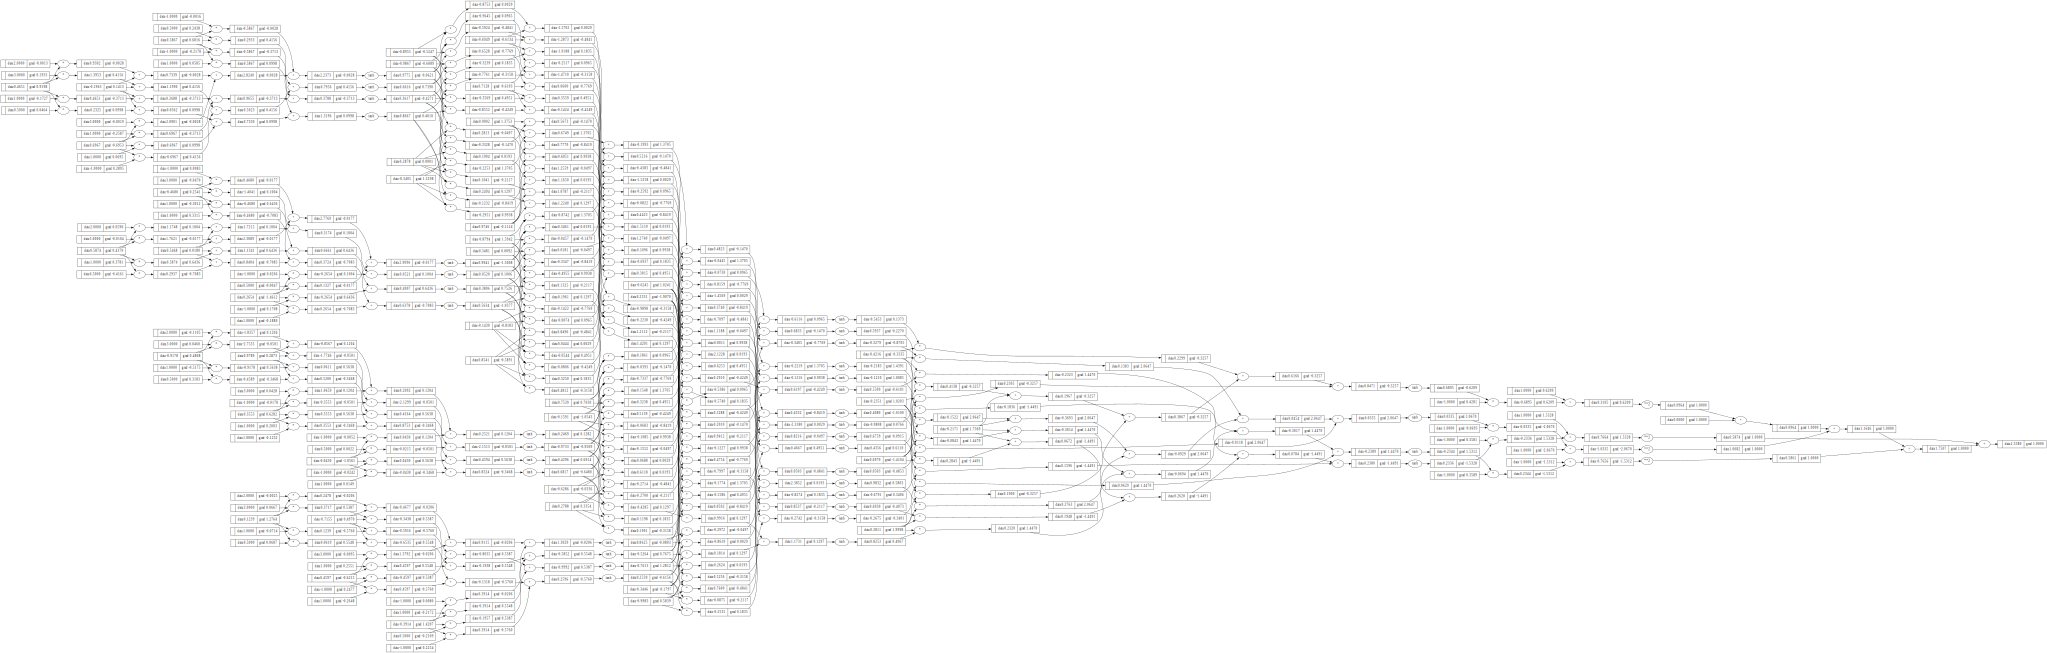

In [30]:
draw_dot(l)

Now that we have determined the gradients with the help of backpropagation, we can perform **gradient descent** in the parameter space of the model.

The gradients are also calculated on the *input data*, which is not that useful, as it is fixed, so we just ignore them.

In [31]:
lr = 0.01  # Learning rate = Step size of updates

for p in n.parameters():  # Update all parameters of the model
  p.data += -lr * p.grad  # Gradients point "uphill" -> As we want to *minimize* the loss, we need to negate the update

This was exactly *one* optimization step.

The loss value for new predictions (on the same data) should now be smaller:

In [32]:
# New forward pass
ypred = [n(x) for x in xs]

# Calculate loss
l = loss(ys, ypred)
l

Value(data=1.9992865506358322)

One step is not really that effective, so we do a lot of steps, e.g. 1000, but usually a lot more ;).

This procedure is called the **training loop** and consists of the:
1. *Forward pass*: Make predictions
2. Calculation of the *loss*
3. *Backward pass*: Calculate gradients
4. *Gradient descent step*: Weight update

In [33]:
lr = 0.01

for k in range(1000):
  # Forward pass
  ypred = [n(x) for x in xs]
  # Calcualte loss
  l = loss(ys, ypred)
  # Backward pass
  n.zero_grad()
  l.backward()
  # Gradient descent step
  for p in n.parameters():
    p.data += -lr * p.grad
  # Print the loss
  print(f"Iteration {k}, loss = {l.data}")

Iteration 0, loss = 1.9992865506358322
Iteration 1, loss = 1.7277314499844534
Iteration 2, loss = 1.5063016335218644
Iteration 3, loss = 1.3226227643011828
Iteration 4, loss = 1.1683685967053625
Iteration 5, loss = 1.0377573975458443
Iteration 6, loss = 0.9265152226776
Iteration 7, loss = 0.8313136782740165
Iteration 8, loss = 0.7494778538446552
Iteration 9, loss = 0.6788238749960356
Iteration 10, loss = 0.6175560355572944
Iteration 11, loss = 0.5641929341815237
Iteration 12, loss = 0.5175099924692468
Iteration 13, loss = 0.47649301935552757
Iteration 14, loss = 0.44030023093162896
Iteration 15, loss = 0.40823113775321684
Iteration 16, loss = 0.37970110822181813
Iteration 17, loss = 0.3542206220835705
Iteration 18, loss = 0.33137837759770183
Iteration 19, loss = 0.31082754607531216
Iteration 20, loss = 0.29227458465058287
Iteration 21, loss = 0.27547012171938423
Iteration 22, loss = 0.26020151864024377
Iteration 23, loss = 0.24628678630290143
Iteration 24, loss = 0.23356959718437306
It

Iteration 264, loss = 0.01162325940893499
Iteration 265, loss = 0.011572194357271852
Iteration 266, loss = 0.011521557171249837
Iteration 267, loss = 0.011471342608781725
Iteration 268, loss = 0.011421545511925963
Iteration 269, loss = 0.011372160805220929
Iteration 270, loss = 0.011323183494058354
Iteration 271, loss = 0.01127460866309497
Iteration 272, loss = 0.011226431474700992
Iteration 273, loss = 0.0111786471674447
Iteration 274, loss = 0.011131251054612237
Iteration 275, loss = 0.011084238522761242
Iteration 276, loss = 0.011037605030307939
Iteration 277, loss = 0.010991346106146545
Iteration 278, loss = 0.010945457348300089
Iteration 279, loss = 0.010899934422601853
Iteration 280, loss = 0.010854773061406774
Iteration 281, loss = 0.010809969062331868
Iteration 282, loss = 0.010765518287024923
Iteration 283, loss = 0.01072141665996084
Iteration 284, loss = 0.010677660167264805
Iteration 285, loss = 0.010634244855561593
Iteration 286, loss = 0.010591166830850358
Iteration 287, l

Iteration 460, loss = 0.006154317483566164
Iteration 461, loss = 0.006139275433865919
Iteration 462, loss = 0.006124304350657974
Iteration 463, loss = 0.006109403740898082
Iteration 464, loss = 0.006094573116053345
Iteration 465, loss = 0.006079811992051026
Iteration 466, loss = 0.006065119889228232
Iteration 467, loss = 0.006050496332281982
Iteration 468, loss = 0.006035940850220312
Iteration 469, loss = 0.006021452976313774
Iteration 470, loss = 0.006007032248047562
Iteration 471, loss = 0.005992678207074563
Iteration 472, loss = 0.005978390399168747
Iteration 473, loss = 0.0059641683741792195
Iteration 474, loss = 0.00595001168598508
Iteration 475, loss = 0.005935919892450585
Iteration 476, loss = 0.005921892555381161
Iteration 477, loss = 0.005907929240479847
Iteration 478, loss = 0.00589402951730441
Iteration 479, loss = 0.005880192959224833
Iteration 480, loss = 0.0058664191433816775
Iteration 481, loss = 0.0058527076506446505
Iteration 482, loss = 0.005839058065571943
Iteration 

Iteration 742, loss = 0.0036135839874540344
Iteration 743, loss = 0.0036082284476864853
Iteration 744, loss = 0.00360288834364177
Iteration 745, loss = 0.0035975636095272865
Iteration 746, loss = 0.00359225417992088
Iteration 747, loss = 0.0035869599897682255
Iteration 748, loss = 0.003581680974380324
Iteration 749, loss = 0.0035764170694309178
Iteration 750, loss = 0.003571168210953925
Iteration 751, loss = 0.0035659343353410646
Iteration 752, loss = 0.003560715379339195
Iteration 753, loss = 0.0035555112800480246
Iteration 754, loss = 0.0035503219749175126
Iteration 755, loss = 0.0035451474017455737
Iteration 756, loss = 0.0035399874986756287
Iteration 757, loss = 0.003534842204194217
Iteration 758, loss = 0.0035297114571285594
Iteration 759, loss = 0.0035245951966444123
Iteration 760, loss = 0.0035194933622435367
Iteration 761, loss = 0.0035144058937614914
Iteration 762, loss = 0.003509332731365362
Iteration 763, loss = 0.0035042738155514398
Iteration 764, loss = 0.00349922908714297

Iteration 977, loss = 0.002673602321250821
Iteration 978, loss = 0.0026706254996727965
Iteration 979, loss = 0.0026676551457847798
Iteration 980, loss = 0.0026646912387660745
Iteration 981, loss = 0.002661733757884708
Iteration 982, loss = 0.0026587826824968595
Iteration 983, loss = 0.0026558379920464314
Iteration 984, loss = 0.002652899666064571
Iteration 985, loss = 0.0026499676841692864
Iteration 986, loss = 0.0026470420260648487
Iteration 987, loss = 0.0026441226715414588
Iteration 988, loss = 0.0026412096004747453
Iteration 989, loss = 0.0026383027928253257
Iteration 990, loss = 0.0026354022286383663
Iteration 991, loss = 0.0026325078880430996
Iteration 992, loss = 0.0026296197512524554
Iteration 993, loss = 0.0026267377985625673
Iteration 994, loss = 0.002623862010352334
Iteration 995, loss = 0.0026209923670830106
Iteration 996, loss = 0.002618128849297832
Iteration 997, loss = 0.0026152714376214406
Iteration 998, loss = 0.0026124201127595997
Iteration 999, loss = 0.0026095748554

Now we can look at the new predictions of our MLP:

In [34]:
ypred

[Value(data=0.9865586266393541),
 Value(data=-0.9769555066793624),
 Value(data=-0.9724520821569678),
 Value(data=0.9662514016915208)]

They are a lot closer to the labels than our first predictions! We have **optimized** on our model with the help of backpropagation.

We can visualize the computation graph of the loss on our model again (and see that the gradients are a lot smaller than before because our error gets smaller):

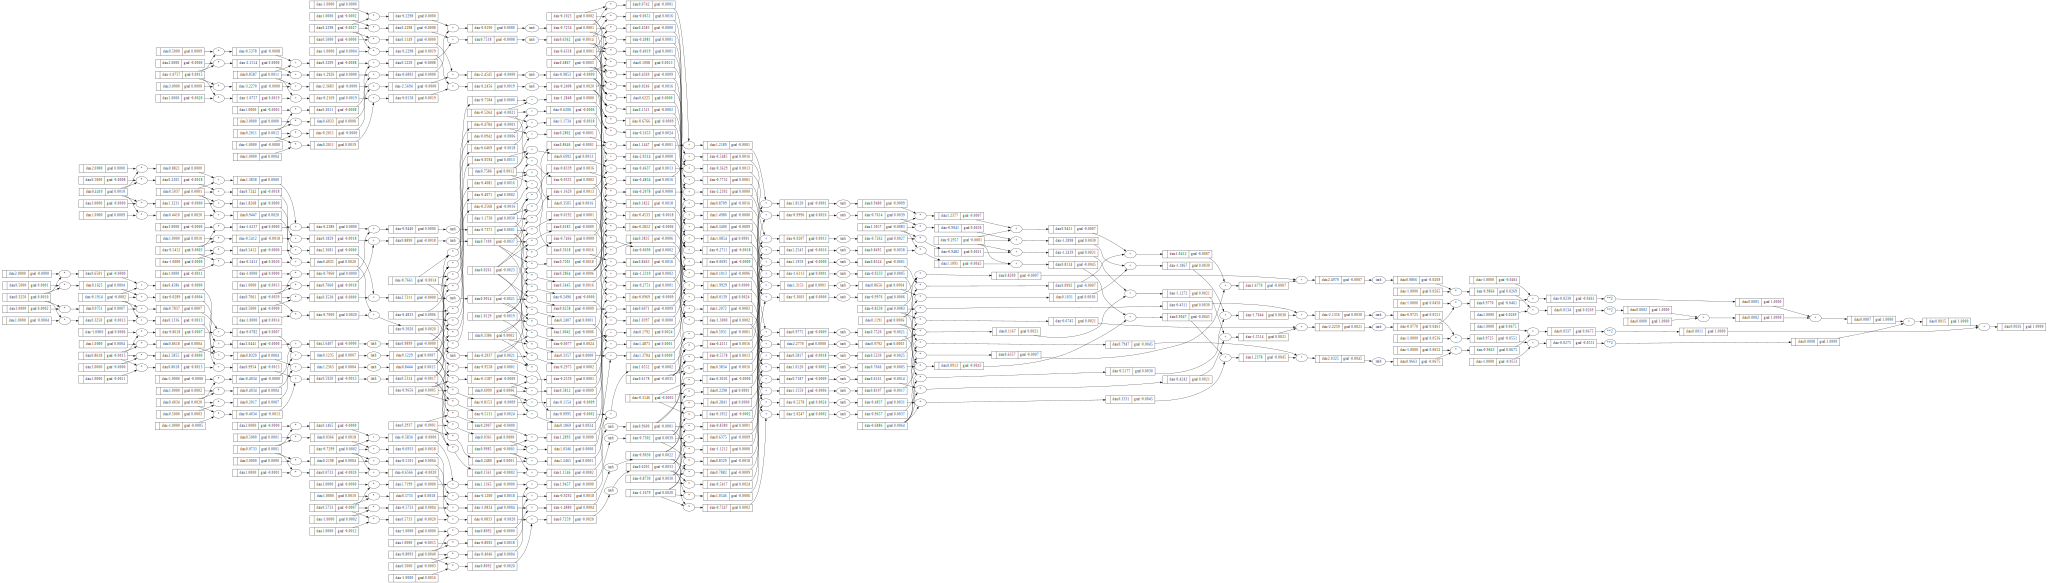

In [35]:
draw_dot(l)